In [1]:
%matplotlib widget
%matplotlib inline
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pickle
import seaborn as sns
import scipy
import emcee
import corner
from IPython.display import display, Math
from tqdm import tqdm
from multiprocessing import Pool

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
import stingray.gti as sting_gti
import stingray.pulse.pulsar as plsr

sns.set_context('paper', font_scale=3.0)
sns.set_palette("colorblind")

# sns.set_style("whitegrid")
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

from stingray_plus import *
    
def FRED_plateau(time, t_0, tau_D, tau_R, t_plateau, A, C):
    # Fast Rise Exponential Decay with plateau from Barriere et al. 2015
    t = time-t_0
    t_peak = np.sqrt(tau_D*tau_R)
    
#     t[t<=0] = 1e-2
#     t[(t-t_plateau) == 0] = t_plateau + 1e-2
    
    rise_mask = ((t <= t_peak) * (t > 0))
    plateau_mask = ((t > t_peak) * (t <= (t_peak + t_plateau)))
    decay_mask = ((t > (t_peak + t_plateau)))
    
    model = np.zeros(np.shape(t))
    
    model[rise_mask] = np.exp(-((tau_R/t[rise_mask]) + (t[rise_mask]/tau_D)))
    model[plateau_mask] = np.exp(-2.0*np.sqrt(tau_R/tau_D))
    model[decay_mask] = np.exp(-((tau_R/(t[decay_mask]-t_plateau)) + ((t[decay_mask]-t_plateau)/tau_D)))
        
    return (A * model) + C

def FRED(time, t_0, tau_D, tau_R, A, C):
    # Fast Rise Exponential Decay with plateau from Barriere et al. 2015
    t = time-t_0
    
    rise_mask = (t > 0)
    model = np.zeros(np.shape(t))
    
    model[rise_mask] = np.exp(-((tau_R/t[rise_mask]) + (t[rise_mask]/tau_D)))        
    return (A * model) + C

def powerlaw_tail(time, t_0, tau_D, tau_R, A, gamma, t_tail, C):
    
    B = A*np.exp(-((tau_R/t_tail) + (t_tail/tau_D)))
    
    t = time-t_0
    rise_mask = (t > 0)
    model = np.zeros(np.shape(t))
    
    model[rise_mask] = np.power(t[rise_mask]/t_tail, -gamma)
    
    return (B*model) + C
    

def FRED_powerlaw(time, t_0, tau_D, tau_R, A, gamma, t_tail, C):
    # Fast Rise Exponential Decay with plateau from Barriere et al. 2015
    t = time-t_0
    
    fred_mask = (t > 0) * (t <= t_tail)
    pl_mask = (t > t_tail)
    model = np.zeros(np.shape(t))
    
    model[fred_mask] = A*np.exp(-((tau_R/t[fred_mask]) + (t[fred_mask]/tau_D)))
    
    B = A*np.exp(-((tau_R/t_tail) + (t_tail/tau_D)))
    
    model[pl_mask] = B*np.power(t[pl_mask]/t_tail, -gamma)
    return model + C

def FRED_2(time, t_1, tau_D1, tau_R1, A1, t_2, tau_D2, tau_R2, A2, C):
    # Fast Rise Exponential Decay with plateau from Barriere et al. 2015
    model1 = FRED(time, t_1, tau_D1, tau_R1, A1, C) - C
    model2 = FRED(time, t_2, tau_D2, tau_R2, A2, C) - C
    
    return model1 + model2 + C

/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/utils.py:21: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/crossspectrum.py:21: UserWarning: Using standard scipy fft
  warnings.warn("Using standard scipy fft")


# Analyze burst shape

In [2]:
if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/GRS_1741d9m2853/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir = '/Volumes/Samsung_1TB/AstroData/GRS_1741d9m2853/'

products_dir = root_dir + '90601317002_products/'
plot_dir = root_dir + 'figures/'


Working on Macbook


In [3]:
plt.ion()
curveA = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu90601317002A01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu90601317002A01_bk.lc'))
curveB = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu90601317002B01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu90601317002B01_bk.lc'))
curve_total = sum_lc(curveA, curveB)
print(curve_total.dt)
curve_10s = curve_total.rebin(dt_new=10.)

t_start = np.min(curve_total.time)


0.5


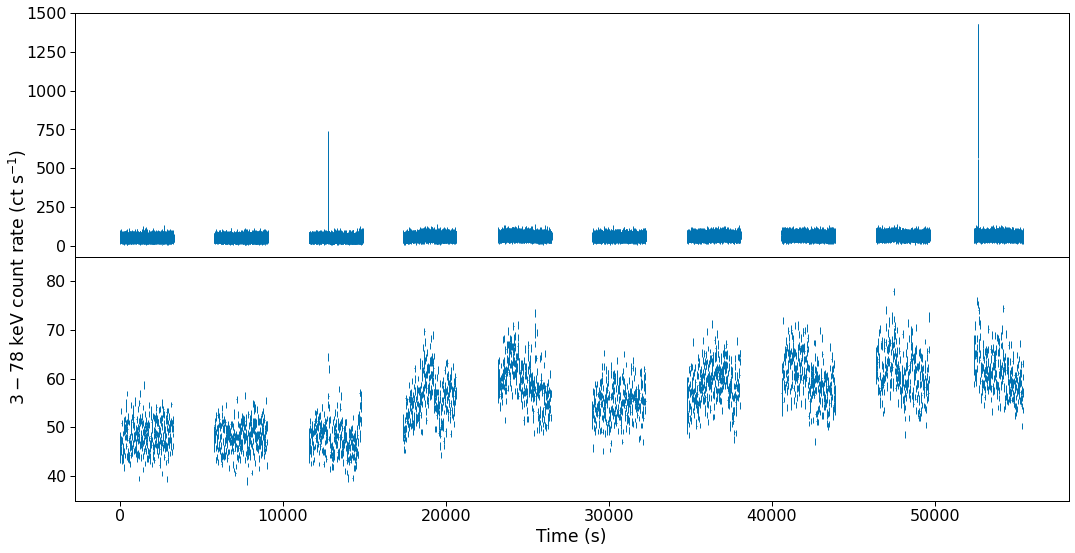

In [4]:
sns.set_context('paper', font_scale=1.8)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,8), sharex=True, gridspec_kw = {'height_ratios':[1,1], 'hspace':0})
ax1.errorbar(curve_total.time-t_start, curve_total.countrate, xerr=curve_total.dt/2., yerr=curve_total.countrate_err, fmt='none', lw = 1.0)
ax2.errorbar(curve_10s.time-t_start, curve_10s.countrate, xerr=curve_10s.dt/2., yerr=curve_10s.countrate_err, fmt='none', lw = 1.0)
fig.text(0, 0.5, str(r'$\mathrm{3-78\ keV\ count\ rate\ (ct\ s^{-1})}$'), va='center', rotation='vertical')
# ax1.set_ylabel(r'$\mathrm{3-78\ keV\ count\ rate\ (ct\ s^{-1})}$')
# ax2.set_ylabel(r'$\mathrm{3-78\ keV\ count\ rate\ (ct\ s^{-1})}$')
ax2.set_ylim((35,85))
ax2.set_xlabel('Time (s)')
plt.tight_layout()



[1.27639531e+04 5.98599157e+00 2.79374175e-02 4.72725902e+02
 1.27523247e+04 2.55905887e+00 2.05773030e+01 1.11588366e+05
 4.42215981e+01]
[1.99223325e-01 4.05108307e-01 1.23166998e-01 9.31233417e+01
 1.30885262e+00 8.35956550e-01 1.44484315e+01 3.25879318e+05
 1.70331949e-01]


0.4089414939895097
0.9015513018294115
7.256619722511683
2.809845209095515


412.35428693196553
148.41298220151953
384.23447572567153
1403.9536615453212


[5.26116263e+04 4.57705914e+00 2.09478085e+00 5.01341539e+03
 1.72433647e+00 1.61167460e+01 5.71236019e+01]
[9.24849426e-02 1.83516600e-01 3.03891375e-01 6.31265076e+02
 9.74579234e-02 8.58702342e-01 1.95153790e-01]


3.0964392165686574
0.2330217808291258
1295.7526765817772
209.82502387292584


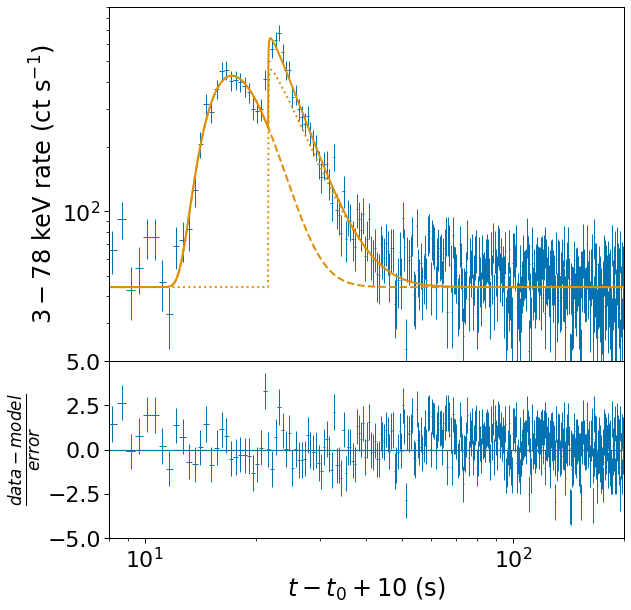

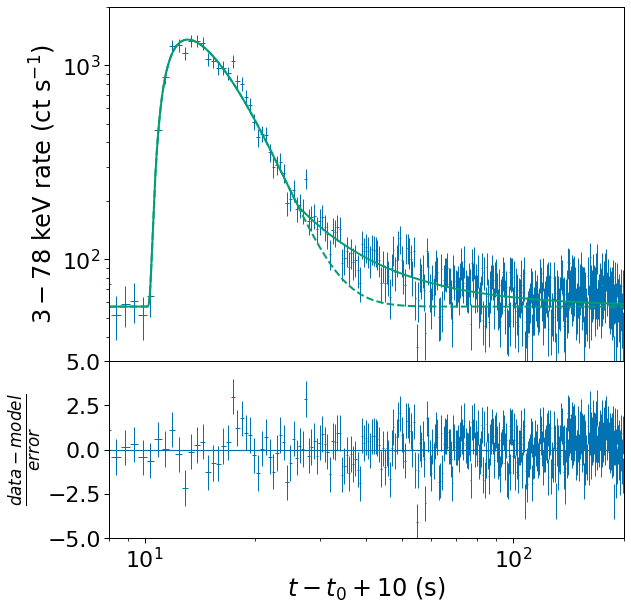

In [5]:
burst1_mask = ((curve_total.time-t_start) > 12000) * ((curve_total.time-t_start) < 15000)
burst2_mask = ((curve_total.time-t_start) > 52000) * ((curve_total.time-t_start) < 56000)
popt1, pcov1 = scipy.optimize.curve_fit(FRED_2, (curve_total.time-t_start)[burst1_mask], curve_total.countrate[burst1_mask], \
                                      p0 = [1.27638517e+04, 5.89010737e+00, 1.69797156e-01, 5.55584128e+02, 1.27524997e+04, 2.32872538e+00, 2.30031086e+01, 2.06747227e+05, 4.43144223e+01], sigma = curve_total.countrate_err[burst1_mask], \
                                       bounds = np.array([[12000., 15000], [0., np.inf], [0., np.inf], [0.0, np.inf], [12000., 15000], [0., np.inf], [0., np.inf], [0.0, np.inf], [0., np.inf]]).T)

chisq1 = np.sum(np.square((curve_total.countrate[burst1_mask]-FRED_2((curve_total.time-t_start)[burst1_mask], *popt1))/curve_total.countrate_err[burst1_mask]))

popt2, pcov2 = scipy.optimize.curve_fit(FRED_powerlaw, (curve_total.time-t_start)[burst2_mask], curve_total.countrate[burst2_mask], \
                                      p0 = [52614., 5., 1., 3000., 1.0, 25., 60.], sigma = curve_total.countrate_err[burst2_mask], \
                                       bounds = np.array([[52000., 56000], [0.0, np.inf], [0., np.inf], [0., np.inf], [0., np.inf], [0., np.inf], [0., np.inf]]).T)

chisq2 = np.sum(np.square((curve_total.countrate[burst2_mask]-FRED_powerlaw((curve_total.time-t_start)[burst2_mask], *popt2))/curve_total.countrate_err[burst2_mask]))



sns.set_context('paper', font_scale=2.5)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9,9), sharex=True, gridspec_kw = {'height_ratios':[2,1], 'hspace':0})
# tmp_start = (popt1[0] + np.sqrt(popt1[1]*popt1[2])) - 10.
tmp_start = np.min([popt1[0], popt1[4]]) - 10.
tmp_mask = ((curve_total.time-t_start) > tmp_start) * ((curve_total.time-t_start) < (np.min([popt1[0], popt1[4]]) + (100.*np.max([popt1[1], popt1[5]]))))
ax1.errorbar((curve_total.time-t_start)[tmp_mask] - tmp_start, curve_total.countrate[tmp_mask], xerr=curve_total.dt/2., yerr=curve_total.countrate_err[tmp_mask], fmt='none', lw = 1)

model_t = np.linspace(((curve_total.time-t_start)[tmp_mask])[0], ((curve_total.time-t_start)[tmp_mask])[-1], 50000)
ax1.plot(model_t-tmp_start, FRED_2(model_t, *popt1), color='C1', lw=2)
ax1.plot(model_t-tmp_start, FRED(model_t, *([*popt1[:4], popt1[-1]])), color='C1', ls='dotted', lw=2)
ax1.plot(model_t-tmp_start, FRED(model_t, *(popt1[4:])), color='C1', ls='dashed', lw=2)

ax2.errorbar((curve_total.time-t_start)[tmp_mask] - tmp_start, (curve_total.countrate[tmp_mask]-FRED_2((curve_total.time-t_start)[tmp_mask], *popt1))/curve_total.countrate_err[tmp_mask], xerr=curve_total.dt/2., yerr=1.0, fmt='none', lw = 1)

ax2.axhline(0.0)
ax1.set_yscale('log')
ax1.set_xlim(8.,200.)
ax1.set_ylim(20.,900.)
ax1.set_xscale('log')
ax2.set_xlabel(r'$t-t_0+10\ (\mathrm{s})$')
ax2.set_ylabel(r'$\frac{data-model}{error}$')
ax2.set_ylim(-5.,5.)
ax1.set_ylabel(r'$\mathrm{3-78\ keV\ rate\ (ct\ s^{-1})}$')
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9,9), sharex=True, gridspec_kw = {'height_ratios':[2,1], 'hspace':0})
# tmp_start = (popt2[0] + np.sqrt(popt2[1]*popt2[2])) - 10.
tmp_start = popt2[0] - 10.
tmp_mask = ((curve_total.time-t_start) > tmp_start) * ((curve_total.time-t_start) < (popt2[0] + 100.*popt2[1]))
ax1.errorbar((curve_total.time-t_start)[tmp_mask] - tmp_start, curve_total.countrate[tmp_mask], xerr=curve_total.dt/2., yerr=curve_total.countrate_err[tmp_mask], fmt='none', lw = 1)

model_t = np.linspace(((curve_total.time-t_start)[tmp_mask])[0], ((curve_total.time-t_start)[tmp_mask])[-1], 50000)
ax1.plot(model_t-tmp_start, FRED_powerlaw(model_t, *popt2), color='C2', lw=2)
ax1.plot(model_t-tmp_start, FRED(model_t, *([*popt2[:4], popt2[-1]])), color='C2', ls='dashed', lw=2)
# ax1.plot(model_t-tmp_start, powerlaw_tail(model_t, *popt2), color='C2', ls='dotted', lw=2)

ax2.errorbar((curve_total.time-t_start)[tmp_mask] - tmp_start, (curve_total.countrate[tmp_mask]-FRED_powerlaw((curve_total.time-t_start)[tmp_mask], *popt2))/curve_total.countrate_err[tmp_mask], xerr=curve_total.dt/2., yerr=1.0, fmt='none', lw = 1)


ax2.axhline(0.0)
ax1.set_yscale('log')
ax1.set_xlim(8.,200.)
ax1.set_ylim(30.,2000.)
ax1.set_xscale('log')
ax2.set_xlabel(r'$t-t_0+10\ (\mathrm{s})$')
ax2.set_ylabel(r'$\frac{data-model}{error}$')
ax2.set_ylim(-5.,5.)
ax1.set_ylabel(r'$\mathrm{3-78\ keV\ rate\ (ct\ s^{-1})}$')
plt.tight_layout()

print(popt1)
print(np.sqrt(np.diag(pcov1)))
print('\n')
print(np.sqrt(popt1[1]*popt1[2]))
print(0.5*np.sqrt((np.diag(pcov1)[2]*popt1[1]/popt1[2]) + np.diag(pcov1)[1]*popt1[2]/popt1[1]))
print(np.sqrt(popt1[5]*popt1[6]))
print(0.5*np.sqrt((np.diag(pcov1)[6]*popt1[5]/popt1[6]) + np.diag(pcov1)[5]*popt1[6]/popt1[5]))
print('\n')
print(popt1[3]*np.exp(-2*np.sqrt(popt1[2]/popt1[1])))
print(popt1[3]*np.exp(-2*np.sqrt(popt1[2]/popt1[1])) * \
      np.sqrt((np.diag(pcov1)[3]/np.square(popt1[3])) +(np.diag(pcov1)[2]/(popt1[1]*popt1[2])) + (np.diag(pcov1)[1]*popt1[2]/np.power(popt1[1], 3))))
print(popt1[7]*np.exp(-2*np.sqrt(popt1[6]/popt1[5])))
print(popt1[7]*np.exp(-2*np.sqrt(popt1[6]/popt1[5])) * \
      np.sqrt((np.diag(pcov1)[7]/np.square(popt1[7])) +(np.diag(pcov1)[6]/(popt1[5]*popt1[6])) + (np.diag(pcov1)[5]*popt1[6]/np.power(popt1[5], 3))))

# print(chisq1/np.sum(burst1_mask))
print('\n')
print(popt2)
print(np.sqrt(np.diag(pcov2)))
print('\n')
print(np.sqrt(popt2[1]*popt2[2]))
print(0.5*np.sqrt((np.diag(pcov2)[2]*popt2[1]/popt2[2]) + np.diag(pcov2)[1]*popt2[2]/popt2[1]))
print(popt2[3]*np.exp(-2*np.sqrt(popt2[2]/popt2[1])))
print(popt2[3]*np.exp(-2*np.sqrt(popt2[2]/popt2[1])) * \
      np.sqrt((np.diag(pcov2)[3]/np.square(popt2[3])) +(np.diag(pcov2)[2]/(popt2[1]*popt2[2])) + (np.diag(pcov2)[1]*popt2[2]/np.power(popt2[1], 3))))


In [6]:
print(4*np.argmax([popt1[0], popt1[4]]))
print(popt1[(4*np.argmax([popt1[0], popt1[4]]))+1])
burst1_gti = [np.min([popt1[0], popt1[4]]) + t_start, np.max([popt1[0], popt1[4]]) + 5.*popt1[(4*np.argmax([popt1[0], popt1[4]]))+1] + t_start]
burst2_gti = [popt2[0] + t_start, popt2[0] + 5.*popt2[1] + t_start]

print(burst1_gti[1]-burst1_gti[0])
print(burst2_gti[1]-burst2_gti[0])

persistent_gti = [[t_start-10., burst1_gti[0]-100],[burst1_gti[1]+500, burst2_gti[0]-100], [burst2_gti[1]+500, np.max(curve_total.time) + 10.]]

persistent_gti_part1 = [[t_start-10., burst1_gti[0]-100.], [burst1_gti[1]+500., t_start + 15000.]]

persistent_gti_part2 = [[burst2_gti[0] - 15000., burst2_gti[0]-100.], [burst2_gti[1]+500., np.max(curve_total.time) + 10.]]

# print(persistent_gti)
# print(persistent_gti_part1)
# print(persistent_gti_part2)

0
5.985991566950669
41.558353543281555
22.885295689105988


In [7]:
primary_hdr = fits.Header()
primary_hdr['HDUCLASS'] = 'OGIP'
primary_hdr['HDUDOC'] = 'OGIP/92-009'
primary_hdu = fits.PrimaryHDU(header=primary_hdr)

gti_hdr = fits.Header()
gti_hdr['HDUCLASS'] = 'OGIP'
gti_hdr['EXTNAME'] = 'GTI'
c1 = fits.Column(name='START', array=[burst1_gti[0]], format='D')
c2 = fits.Column(name='STOP', array=[burst1_gti[1]], format='D')
gti_hdu = fits.BinTableHDU.from_columns([c1, c2], header = gti_hdr)

hdul = fits.HDUList([primary_hdu, gti_hdu])
hdul.writeto(root_dir+'burst1/' + 'burst1_gti.fits', overwrite=True)

##################################

primary_hdr = fits.Header()
primary_hdr['HDUCLASS'] = 'OGIP'
primary_hdr['HDUDOC'] = 'OGIP/92-009'
primary_hdu = fits.PrimaryHDU(header=primary_hdr)

gti_hdr = fits.Header()
gti_hdr['HDUCLASS'] = 'OGIP'
gti_hdr['EXTNAME'] = 'GTI'
c1 = fits.Column(name='START', array=[burst2_gti[0]], format='D')
c2 = fits.Column(name='STOP', array=[burst2_gti[1]], format='D')
gti_hdu = fits.BinTableHDU.from_columns([c1, c2], header = gti_hdr)

hdul = fits.HDUList([primary_hdu, gti_hdu])
hdul.writeto(root_dir + 'burst2/' +'burst2_gti.fits', overwrite=True)

##################################

short_gtis_1 = np.array([4.0, *[2.0 for i in range(7)], *np.logspace(np.log10(4.0), 2, 7)])
print(len(short_gtis_1))
print(sum(short_gtis_1))

print(short_gtis_1)
arf_start = 0
for i, x in enumerate(short_gtis_1):
    if np.sum(short_gtis_1[arf_start:i+1]) > 4.0:
        temp_gti = [[burst1_gti[0] + np.sum(short_gtis_1[:arf_start]), burst1_gti[0] + np.sum(short_gtis_1[:i+1])]]
        print(temp_gti)
        primary_hdr = fits.Header()
        primary_hdr['HDUCLASS'] = 'OGIP'
        primary_hdr['HDUDOC'] = 'OGIP/92-009'
        primary_hdu = fits.PrimaryHDU(header=primary_hdr)

        gti_hdr = fits.Header()
        gti_hdr['HDUCLASS'] = 'OGIP'
        gti_hdr['EXTNAME'] = 'GTI'
        c1 = fits.Column(name='START', array=[temp_gti[0][0]], format='D')
        c2 = fits.Column(name='STOP', array=[temp_gti[0][1]], format='D')
        gti_hdu = fits.BinTableHDU.from_columns([c1, c2], header = gti_hdr)

        hdul = fits.HDUList([primary_hdu, gti_hdu])
        hdul.writeto(root_dir + 'burst1/gtis/' +'burst1_seg' + str(arf_start) + '_' + str(i) + '_arfgti.fits', overwrite=True)
        arf_start = i + 1


    # temp_gti = sting_gti.cross_two_gtis([[burst1_gti[0] + np.sum(short_gtis_1[:i]), burst1_gti[0] + np.sum(short_gtis_1[:i+1])]], curve_total.gti)
    temp_gti = [[burst1_gti[0] + np.sum(short_gtis_1[:i]), burst1_gti[0] + np.sum(short_gtis_1[:i+1])]]
    print(temp_gti)
    primary_hdr = fits.Header()
    primary_hdr['HDUCLASS'] = 'OGIP'
    primary_hdr['HDUDOC'] = 'OGIP/92-009'
    primary_hdu = fits.PrimaryHDU(header=primary_hdr)

    gti_hdr = fits.Header()
    gti_hdr['HDUCLASS'] = 'OGIP'
    gti_hdr['EXTNAME'] = 'GTI'
    c1 = fits.Column(name='START', array=[temp_gti[0][0]], format='D')
    c2 = fits.Column(name='STOP', array=[temp_gti[0][1]], format='D')
    gti_hdu = fits.BinTableHDU.from_columns([c1, c2], header = gti_hdr)

    hdul = fits.HDUList([primary_hdu, gti_hdu])
    hdul.writeto(root_dir + 'burst1/gtis/' +'burst1_seg' + str(i) + '_gti.fits', overwrite=True)
    
short_gtis_2 = np.array([1.5, *[1.0 for i in range(9)], *np.logspace(0, 2, 10)])
print(len(short_gtis_2))
print(sum(short_gtis_2))

print(short_gtis_2)
arf_start = 0
for i, x in enumerate(short_gtis_2):
    
    if np.sum(short_gtis_2[arf_start:i+1]) > 4.0:
        temp_gti = [[burst2_gti[0] + np.sum(short_gtis_2[:arf_start]), burst2_gti[0] + np.sum(short_gtis_2[:i+1])]]
        print(temp_gti)
        primary_hdr = fits.Header()
        primary_hdr['HDUCLASS'] = 'OGIP'
        primary_hdr['HDUDOC'] = 'OGIP/92-009'
        primary_hdu = fits.PrimaryHDU(header=primary_hdr)

        gti_hdr = fits.Header()
        gti_hdr['HDUCLASS'] = 'OGIP'
        gti_hdr['EXTNAME'] = 'GTI'
        c1 = fits.Column(name='START', array=[temp_gti[0][0]], format='D')
        c2 = fits.Column(name='STOP', array=[temp_gti[0][1]], format='D')
        gti_hdu = fits.BinTableHDU.from_columns([c1, c2], header = gti_hdr)

        hdul = fits.HDUList([primary_hdu, gti_hdu])
        hdul.writeto(root_dir + 'burst2/gtis/' +'burst2_seg' + str(arf_start) + '_' + str(i) + '_arfgti.fits', overwrite=True)
        arf_start = i + 1


    # temp_gti = sting_gti.cross_two_gtis([[burst2_gti[0] + np.sum(short_gtis_2[:i]), burst2_gti[0] + np.sum(short_gtis_2[:i+1])]], curve_total.gti)
    temp_gti = [[burst2_gti[0] + np.sum(short_gtis_2[:i]), burst2_gti[0] + np.sum(short_gtis_2[:i+1])]]
    print(temp_gti)
    primary_hdr = fits.Header()
    primary_hdr['HDUCLASS'] = 'OGIP'
    primary_hdr['HDUDOC'] = 'OGIP/92-009'
    primary_hdu = fits.PrimaryHDU(header=primary_hdr)

    gti_hdr = fits.Header()
    gti_hdr['HDUCLASS'] = 'OGIP'
    gti_hdr['EXTNAME'] = 'GTI'
    c1 = fits.Column(name='START', array=[temp_gti[0][0]], format='D')
    c2 = fits.Column(name='STOP', array=[temp_gti[0][1]], format='D')
    gti_hdu = fits.BinTableHDU.from_columns([c1, c2], header = gti_hdr)

    hdul = fits.HDUList([primary_hdu, gti_hdu])
    hdul.writeto(root_dir + 'burst2/gtis/' + 'burst2_seg' + str(i) + '_gti.fits', overwrite=True)
    
    
##################################
    
    
primary_hdr = fits.Header()
primary_hdr['HDUCLASS'] = 'OGIP'
primary_hdr['HDUDOC'] = 'OGIP/92-009'
primary_hdu = fits.PrimaryHDU(header=primary_hdr)

gti_hdr = fits.Header()
gti_hdr['HDUCLASS'] = 'OGIP'
gti_hdr['EXTNAME'] = 'GTI'
c1 = fits.Column(name='START', array=[burst1_gti[0]], format='D')
c2 = fits.Column(name='STOP', array=[burst1_gti[0] + sum(short_gtis_1)], format='D')
gti_hdu = fits.BinTableHDU.from_columns([c1, c2], header = gti_hdr)

hdul = fits.HDUList([primary_hdu, gti_hdu])
hdul.writeto(root_dir+'burst1/' + 'burst1_full_gti.fits', overwrite=True)

##################################

primary_hdr = fits.Header()
primary_hdr['HDUCLASS'] = 'OGIP'
primary_hdr['HDUDOC'] = 'OGIP/92-009'
primary_hdu = fits.PrimaryHDU(header=primary_hdr)

gti_hdr = fits.Header()
gti_hdr['HDUCLASS'] = 'OGIP'
gti_hdr['EXTNAME'] = 'GTI'
c1 = fits.Column(name='START', array=[burst2_gti[0]], format='D')
c2 = fits.Column(name='STOP', array=[burst2_gti[0] + sum(short_gtis_2)], format='D')
gti_hdu = fits.BinTableHDU.from_columns([c1, c2], header = gti_hdr)

hdul = fits.HDUList([primary_hdu, gti_hdu])
hdul.writeto(root_dir + 'burst2/' +'burst2_full_gti.fits', overwrite=True)


15
253.21584843734945
[  4.           2.           2.           2.           2.
   2.           2.           2.           4.           6.83990379
  11.69607095  20.          34.19951893  58.48035476 100.        ]
[[326544372.8247183, 326544376.8247183]]
[[326544372.8247183, 326544378.8247183]]
[[326544376.8247183, 326544378.8247183]]
[[326544378.8247183, 326544380.8247183]]
[[326544380.8247183, 326544382.8247183]]
[[326544378.8247183, 326544384.8247183]]
[[326544382.8247183, 326544384.8247183]]
[[326544384.8247183, 326544386.8247183]]
[[326544386.8247183, 326544388.8247183]]
[[326544384.8247183, 326544390.8247183]]
[[326544388.8247183, 326544390.8247183]]
[[326544390.8247183, 326544394.8247183]]
[[326544390.8247183, 326544401.66462207]]
[[326544394.8247183, 326544401.66462207]]
[[326544401.66462207, 326544413.36069304]]
[[326544401.66462207, 326544413.36069304]]
[[326544413.36069304, 326544433.36069304]]
[[326544413.36069304, 326544433.36069304]]
[[326544433.36069304, 326544467.5602119

In [8]:
log_area = 45.768

stef_boltz_cgs = 5.6704E-5
boltz_keV = 8.6173E-8

L_const = (49/25) * np.pi*stef_boltz_cgs*1.0E10/np.power(boltz_keV, 4)

PRE_data1 = np.loadtxt('/Users/sean/Desktop/GRS_PRE/Burst 1-min5_fast-Table 1.csv', delimiter=',', dtype=str)[1:]
PRE_data2 = np.loadtxt('/Users/sean/Desktop/GRS_PRE/Burst 2-min5_fast-Table 1.csv', delimiter=',', dtype=str)[1:]

PRE_data1[PRE_data1==''] = np.inf
PRE_data2[PRE_data2==''] = np.inf

PRE_data1 = PRE_data1.astype(float)
PRE_data2 = PRE_data2.astype(float)

In [9]:
burst1_times = np.cumsum(short_gtis_1)-short_gtis_1/2
burst2_times = np.cumsum(short_gtis_2)-short_gtis_2/2

PRE_ind1 = []
for i in range(len(PRE_data1)):
    if np.inf not in PRE_data1[i]:
        PRE_ind1.append(i)
PRE_ind1 = np.array(PRE_ind1)
        
PRE_ind2 = []
for i in range(len(PRE_data2)):
    if np.inf not in PRE_data2[i]:
        PRE_ind2.append(i)
PRE_ind2 = np.array(PRE_ind2)


[2.44635793e+36 2.78509491e+37 4.37411302e+37 3.63722360e+37
 3.33579997e+37 6.76550158e+37 4.22824360e+37 2.66041875e+37
 1.52967793e+37 6.69637860e+36 2.48387651e+36 1.19077580e+36
 4.94880111e+35]
[1.80385 2.23549 2.06238 1.88255 1.82128 2.33537 2.06025 1.62512 1.3861
 1.14662 0.9247  1.51813 3.50076]


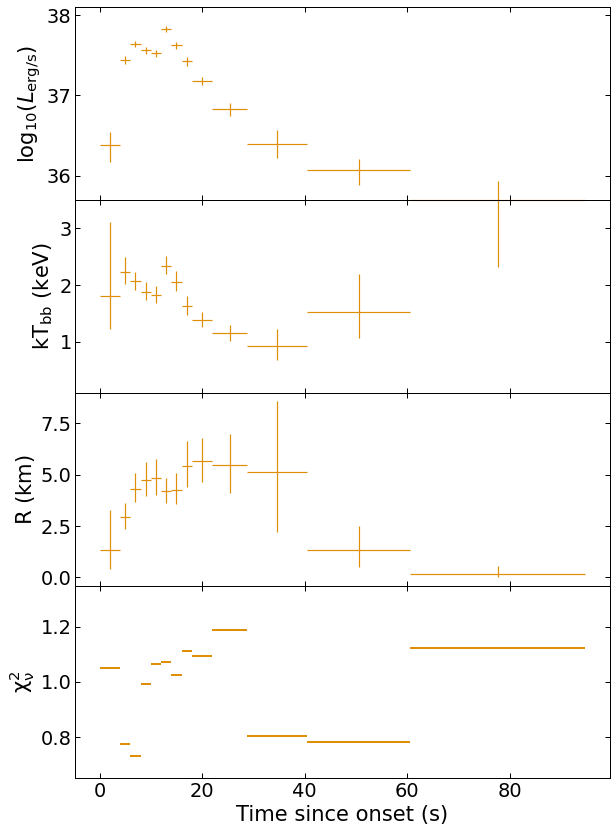

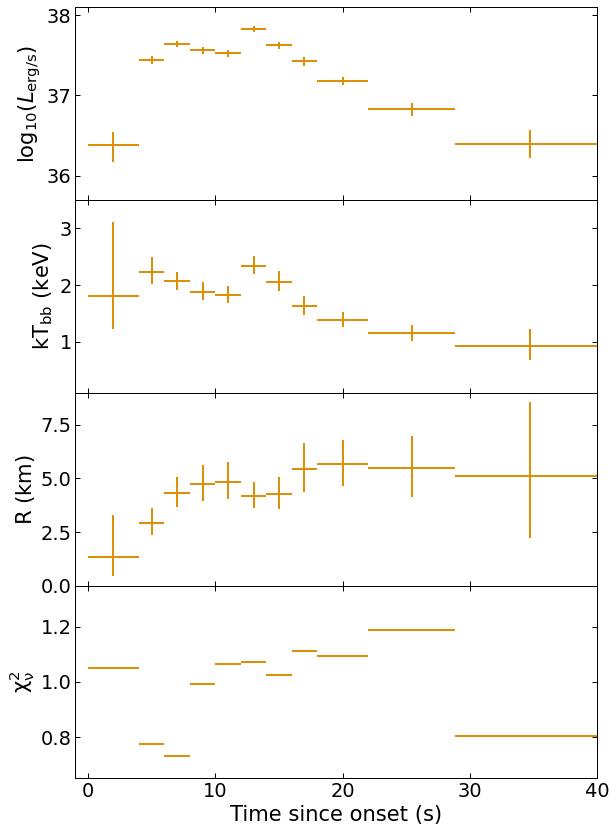

In [10]:
kT = PRE_data1[PRE_ind1].T[4]
kT_minus = PRE_data1[PRE_ind1].T[5]
kT_plus = PRE_data1[PRE_ind1].T[6]

logbbFlux = PRE_data1[PRE_ind1].T[1]
logbbFlux_minus = PRE_data1[PRE_ind1].T[2]
logbbFlux_plus = PRE_data1[PRE_ind1].T[3]

red_chi = PRE_data1[PRE_ind1].T[8]/PRE_data1[PRE_ind1].T[9]

L_D72 = log_area + logbbFlux
L_err_minus = logbbFlux_minus
L_err_plus = logbbFlux_plus

print(np.power(10, L_D72))
print(kT)

log_Rkm_D7 = (logbbFlux - 4*np.log10(kT) - np.log10(stef_boltz_cgs/(np.power(boltz_keV, 4)*4.6656E+34)))/2
Rkm_D7 = np.power(10, log_Rkm_D7)
Rkm_D7_minus = (Rkm_D7/np.log10(np.e)) * np.sqrt(np.square(logbbFlux_minus/2) + np.square(2*np.log10(np.e)*kT_minus/kT))
Rkm_D7_plus = (Rkm_D7/np.log10(np.e)) * np.sqrt(np.square(logbbFlux_plus/2) + np.square(2*np.log10(np.e)*kT_plus/kT))

sns.set_context('paper', font_scale=2.2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(9,12), sharex=True, gridspec_kw = {'height_ratios':[1,1,1,1], 'hspace':0})

ax2.errorbar(burst1_times[PRE_ind1], kT, xerr=short_gtis_1[PRE_ind1]/2, \
             yerr=(kT_minus, kT_plus), fmt='none', lw=1.2, color='C1')

ax1.errorbar(burst1_times[PRE_ind1], L_D72, xerr=short_gtis_1[PRE_ind1]/2, \
             yerr=(L_err_minus, L_err_plus), fmt='none', lw=1.2, color='C1')

ax3.errorbar(burst1_times[PRE_ind1], Rkm_D7, xerr=short_gtis_1[PRE_ind1]/2, \
             yerr=(Rkm_D7_minus, Rkm_D7_plus), fmt='none', lw=1.2, color='C1')

ax4.errorbar(burst1_times[PRE_ind1], red_chi, xerr=short_gtis_1[PRE_ind1]/2, fmt='none', lw=2.0, color='C1')



ax2.set_ylabel(r'$\mathrm{kT_{bb}\ (keV)}$')
ax1.set_ylabel(r'$\log_{10}(L_{\mathrm{erg/s}})$')
ax3.set_ylabel(r'$\mathrm{R\ (km)}$')
ax4.set_ylabel(r'$\mathrm{\chi^{2}_{\nu}}$')
ax4.set_xlabel('Time since onset (s)')

ax1.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax2.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax3.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax4.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)

# ax1.set_xlim((-1, 60))
ax1.set_ylim((35.7,38.1))
ax2.set_ylim((0.1,3.5))
ax4.set_ylim((0.65,1.35))


plt.tight_layout()

plt.savefig(plot_dir+'burst1_PRE_new.pdf')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(9,12), sharex=True, gridspec_kw = {'height_ratios':[1,1,1,1], 'hspace':0})

ax2.errorbar(burst1_times[PRE_ind1], kT, xerr=short_gtis_1[PRE_ind1]/2, \
             yerr=(kT_minus, kT_plus), fmt='none', lw=2.0, color='C1')

ax1.errorbar(burst1_times[PRE_ind1], L_D72, xerr=short_gtis_1[PRE_ind1]/2, \
             yerr=(L_err_minus, L_err_plus), fmt='none', lw=2.0, color='C1')

ax3.errorbar(burst1_times[PRE_ind1], Rkm_D7, xerr=short_gtis_1[PRE_ind1]/2, \
             yerr=(Rkm_D7_minus, Rkm_D7_plus), fmt='none', lw=2.0, color='C1')

ax4.errorbar(burst1_times[PRE_ind1], red_chi, xerr=short_gtis_1[PRE_ind1]/2, fmt='none', lw=2.0, color='C1')



ax2.set_ylabel(r'$\mathrm{kT_{bb}\ (keV)}$')
ax1.set_ylabel(r'$\log_{10}(L_{\mathrm{erg/s}})$')
ax3.set_ylabel(r'$\mathrm{R\ (km)}$')
ax4.set_ylabel(r'$\mathrm{\chi^{2}_{\nu}}$')
ax4.set_xlabel('Time since onset (s)')

ax1.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax2.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax3.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax4.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)

ax1.set_xlim((-1, 40))
ax1.set_ylim((35.7,38.1))
ax2.set_ylim((0.1,3.5))
ax3.set_ylim(bottom=0)
ax4.set_ylim((0.65,1.35))


plt.tight_layout()

plt.savefig(plot_dir+'burst1_PRE_new_zoom.pdf')


2.939611921647233e-08
1.7230187361378545e+38
[1.66537374 8.71340323 8.47117968 6.12245554 5.43394964 4.94945164
 5.44551964 4.88334629 5.49195375 4.31627066 4.5479539  4.53816085
 4.62617076 4.67157668 4.99918167 4.17103261 2.64141274 1.48238572
 1.18343739 1.11015137]
[  0.75         2.           3.           4.           5.
   6.           7.           8.           9.          10.
  11.          12.33405027  14.55938024  18.27145436  24.46356719
  34.79263392  52.0225557   80.76379747 128.7070783  208.68129082]
[2.74294 1.90394 1.99009 2.44233 2.48745 2.5074  2.32911 2.4663  2.12049
 2.25074 2.04723 1.89035 1.70091 1.50368 1.25031 1.22318 1.27943 1.42645
 1.35857 1.14605]


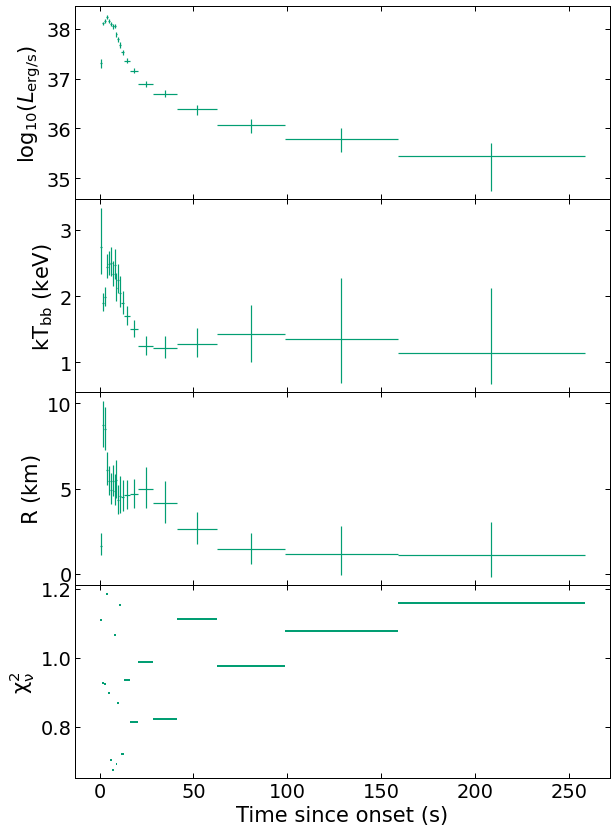

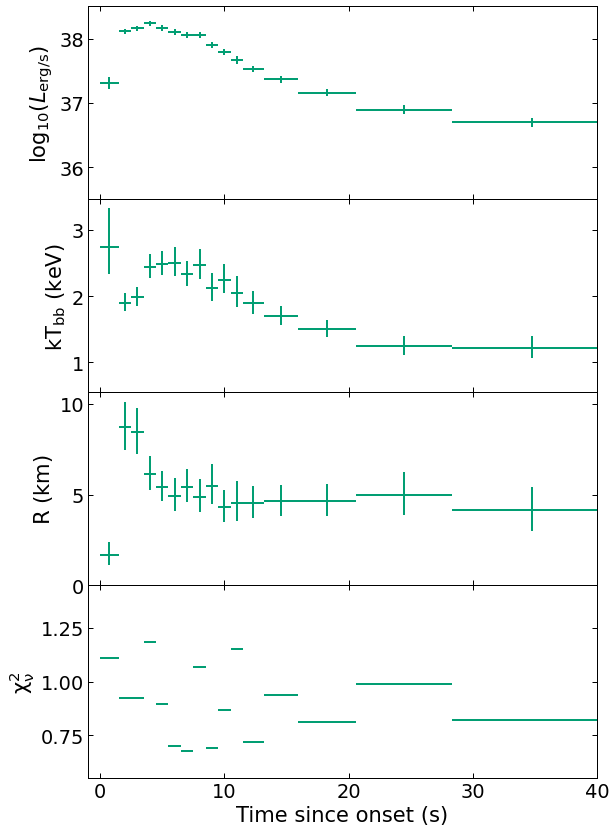

In [11]:
kT = PRE_data2[PRE_ind2].T[4]
kT_minus = PRE_data2[PRE_ind2].T[5]
kT_plus = PRE_data2[PRE_ind2].T[6]

logbbFlux = PRE_data2[PRE_ind2].T[1]
logbbFlux_minus = PRE_data2[PRE_ind2].T[2]
logbbFlux_plus = PRE_data2[PRE_ind2].T[3]

red_chi = PRE_data2[PRE_ind2].T[8]/PRE_data2[PRE_ind2].T[9]

L_D72 = log_area + logbbFlux
L_err_minus = logbbFlux_minus
L_err_plus = logbbFlux_plus

log_Rkm_D7 = (logbbFlux - 4*np.log10(kT) - np.log10(stef_boltz_cgs/(np.power(boltz_keV, 4)*4.6656E+34)))/2
log_Rkm_D7_minus = np.sqrt(np.square(logbbFlux_minus/2) + np.square(2*np.log10(np.e)*kT_minus/kT))
log_Rkm_D7_plus = np.sqrt(np.square(logbbFlux_plus/2) + np.square(2*np.log10(np.e)*kT_plus/kT))
Rkm_D7 = np.power(10, log_Rkm_D7)
Rkm_D7_minus = (Rkm_D7/np.log10(np.e)) * np.sqrt(np.square(logbbFlux_minus/2) + np.square(2*np.log10(np.e)*kT_minus/kT))
Rkm_D7_plus = (Rkm_D7/np.log10(np.e)) * np.sqrt(np.square(logbbFlux_plus/2) + np.square(2*np.log10(np.e)*kT_plus/kT))

print(np.max(np.power(10,logbbFlux)))
print(np.max(np.power(10,L_D72)))
print(np.power(10,log_Rkm_D7))
print(burst2_times[PRE_ind2])
print(kT)

sns.set_context('paper', font_scale=2.2)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(9,12), sharex=True, gridspec_kw = {'height_ratios':[1,1,1,1], 'hspace':0})

ax2.errorbar(burst2_times[PRE_ind2], kT, xerr=short_gtis_2[PRE_ind2]/2, \
             yerr=(kT_minus, kT_plus), fmt='none', lw=1.2, color='C2')

ax1.errorbar(burst2_times[PRE_ind2], L_D72, xerr=short_gtis_2[PRE_ind2]/2, \
             yerr=(L_err_minus, L_err_plus), fmt='none', lw=1.2, color='C2')

ax3.errorbar(burst2_times[PRE_ind2], Rkm_D7, xerr=short_gtis_2[PRE_ind2]/2, \
             yerr=(Rkm_D7_minus, Rkm_D7_plus), fmt='none', lw=1.2, color='C2')

ax4.errorbar(burst2_times[PRE_ind2], red_chi, xerr=short_gtis_2[PRE_ind2]/2, fmt='none', lw=2.0, color='C2')

ax2.set_ylabel(r'$\mathrm{kT_{bb}\ (keV)}$')
ax1.set_ylabel(r'$\log_{10}(L_{\mathrm{erg/s}})$')
ax3.set_ylabel(r'$\mathrm{R\ (km)}$')
ax4.set_ylabel(r'$\mathrm{\chi^{2}_{\nu}}$')
ax4.set_xlabel('Time since onset (s)')


ax1.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax2.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax3.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax4.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)


plt.tight_layout()

plt.savefig(plot_dir+'burst2_PRE_new.pdf')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(9,12), sharex=True, gridspec_kw = {'height_ratios':[1,1,1,1], 'hspace':0})

ax2.errorbar(burst2_times[PRE_ind2], kT, xerr=short_gtis_2[PRE_ind2]/2, \
             yerr=(kT_minus, kT_plus), fmt='none', lw=2.0, color='C2')

ax1.errorbar(burst2_times[PRE_ind2], L_D72, xerr=short_gtis_2[PRE_ind2]/2, \
             yerr=(L_err_minus, L_err_plus), fmt='none', lw=2.0, color='C2')

ax3.errorbar(burst2_times[PRE_ind2], Rkm_D7, xerr=short_gtis_2[PRE_ind2]/2, \
             yerr=(Rkm_D7_minus, Rkm_D7_plus), fmt='none', lw=2.0, color='C2')

ax4.errorbar(burst2_times[PRE_ind2], red_chi, xerr=short_gtis_2[PRE_ind2]/2, fmt='none', lw=2.0, color='C2')


ax2.set_ylabel(r'$\mathrm{kT_{bb}\ (keV)}$')
ax1.set_ylabel(r'$\log_{10}(L_{\mathrm{erg/s}})$')
ax3.set_ylabel(r'$\mathrm{R\ (km)}$')
ax4.set_ylabel(r'$\mathrm{\chi^{2}_{\nu}}$')
ax4.set_xlabel('Time since onset (s)')


ax1.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax2.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax3.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax4.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)




ax3.set_xlim((-1,40))
ax1.set_ylim((35.5,38.5))
#ax2.set_ylim((1,3))
#ax3.set_ylim((0.5,9.5))
ax3.set_ylim(bottom=0)
ax4.set_ylim((0.55,1.45))


plt.tight_layout()

plt.savefig(plot_dir+'burst2_PRE_new_zoom.pdf')




In [50]:
print(np.power(10,logbbFlux))
print(np.power(10, logbbFlux + logbbFlux_plus) - np.power(10,logbbFlux))
print(np.power(10,logbbFlux) - np.power(10, logbbFlux - logbbFlux_minus))
print(Rkm_D7)

[3.46027010e-09 2.19892289e-08 2.48084711e-08 2.93961192e-08
 2.49155225e-08 2.13417486e-08 1.92335743e-08 1.94464352e-08
 1.34406416e-08 1.05375585e-08 8.00792506e-09 5.79628859e-09
 3.94811687e-09 2.45906495e-09 1.34613929e-09 8.58361045e-10
 4.12059565e-10 2.00525681e-10 1.05157439e-10 4.68597535e-11]
[8.14837993e-10 2.04048500e-09 2.31129879e-09 2.83111237e-09
 2.49165416e-09 2.36688908e-09 2.04105491e-09 2.26181911e-09
 1.59573867e-09 1.33596999e-09 1.13929864e-09 7.03936569e-10
 4.53087140e-10 2.99471963e-10 2.11894242e-10 1.50488726e-10
 9.61665763e-11 6.61730811e-11 6.55714446e-11 4.18315423e-11]
[6.42049403e-10 1.92405167e-09 2.17586316e-09 2.59997540e-09
 2.29503298e-09 2.13254323e-09 1.88191949e-09 1.99920863e-09
 1.45635737e-09 1.22467010e-09 1.03871748e-09 6.58934500e-10
 4.27360287e-10 2.81717688e-10 1.94439997e-10 1.37250079e-10
 8.96766635e-11 6.18232733e-11 4.70982451e-11 3.72295160e-11]
[1.66537374 8.71340323 8.47117968 6.12245554 5.43394964 4.94945164
 5.44551964 4.8

In [41]:
subburst1_energy = np.sum((np.power(10, (PRE_data1[PRE_ind1].T[1]+log_area))*short_gtis_1[PRE_ind1])[:4])
subburst2_energy = np.sum((np.power(10, (PRE_data1[PRE_ind1].T[1]+log_area))*short_gtis_1[PRE_ind1])[4:])

burst1_energy = subburst1_energy + subburst2_energy

burst2_energy = np.sum(np.power(10, (PRE_data2[PRE_ind2].T[1]+log_area))*short_gtis_2[PRE_ind2])

print(subburst1_energy)
print(subburst2_energy)
print(burst2_energy)

2.2571406226569684e+38
5.1658075401203135e+38
1.6350860941602774e+39


In [42]:
CNO_keV = 26.7 * 1000
CNO_erg = 4.278E-5
H_mass_kg = 1.674E-27
print((burst1_energy/CNO_erg)*4*H_mass_kg)
print((burst2_energy/CNO_erg)*4*H_mass_kg)

1.1618527559129659e+17
2.5592651908595645e+17


In [43]:
triplealpha_keV = 7.275 * 1000
triplealpha_erg = 1.166E-5
He_mass_kg = 6.6465E-27
print((burst1_energy/triplealpha_erg)*3*He_mass_kg)
print((burst2_energy/triplealpha_erg)*3*He_mass_kg)

1.2693814313181614e+18
2.796123428345528e+18
